# Segmentasi Arteri Karotis dengan Deep Learning + Stretch

Notebook ini dibuat berdasarkan implementasi tugas akhir yang berjudul *Segmentasi Arteri Karotis pada Citra Ultrasound Berbasis Deep Learning untuk Estimasi Elastisitas Pembuluh Darah*.

## 1. Import Library dan Setup

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

c:\Users\Ridho\anaconda3\envs\ridho-ta\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda


## 2. Preprocessing dan Augmentasi Citra

In [2]:
def get_augmentations(img_size=(512, 512)):
    train_transform = A.Compose([
        A.Resize(*img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),

        # Stretching / Warping secara eksplisit:
        A.OneOf([
            A.Affine(scale=(0.8, 1.2), shear={"x": (-10, 10)}, p=0.5),  # horizontal stretch
            A.Affine(scale=(0.8, 1.2), shear={"y": (-10, 10)}, p=0.5),  # vertical stretch
        ], p=0.5),

        A.ShiftScaleRotate(0.1, 0.1, 45, p=0.5),
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            A.MultiplicativeNoise(p=0.3)
        ], p=0.4),
        A.CLAHE(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], additional_targets={'mask': 'mask'})

    test_transform = A.Compose([
        A.Resize(*img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], additional_targets={'mask': 'mask'})

    return train_transform, test_transform

## 3. Dataset dan DataLoader

In [3]:
class EnhancedCarotidDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask > 0).astype(np.float32)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## 4. Arsitektur Model U-Net

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.bottleneck = conv_block(512, 1024)

        self.pool = nn.MaxPool2d(2)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, 2)

        self.dec4 = conv_block(1024, 512)
        self.dec3 = conv_block(512, 256)
        self.dec2 = conv_block(256, 128)
        self.dec1 = conv_block(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.dec4(torch.cat([self.upconv4(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], dim=1))

        return torch.sigmoid(self.out_conv(dec1))

## 5. Evaluasi dan Fungsi Loss

In [5]:
def calculate_dice_coefficient(pred, target):
    smooth = 1e-6
    pred_binary = (pred > 0.5).float()
    intersection = (pred_binary * target).sum()
    return (2. * intersection + smooth) / (pred_binary.sum() + target.sum() + smooth)

def calculate_iou(pred, target):
    smooth = 1e-6
    pred_binary = (pred > 0.5).float()
    intersection = (pred_binary * target).sum()
    union = pred_binary.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_accuracy(pred, target):
    pred_binary = (pred > 0.5).float()
    correct = (pred_binary == target).float().sum()
    total = target.numel()
    return correct / total

def dice_loss(pred, target):
    smooth = 1e-6
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def mixed_loss(pred, target):
    if target.dim() == 4 and target.size(1) == 1:
        pass
    elif target.dim() == 3:
        target = target.unsqueeze(1)
    bce = nn.BCELoss()(pred, target)
    intersection = (pred * target).sum()
    dice = 1 - (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)
    return bce + dice

## 6. Pelatihan dan Validasi Model

In [6]:
def evaluate_metrics(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum()
    fn = ((1 - pred) * target).sum()
    tn = ((1 - pred) * (1 - target)).sum()

    dice = (2. * tp) / (pred.sum() + target.sum() + 1e-6)
    iou = tp / (tp + fp + fn + 1e-6)
    acc = (tp + tn) / (tp + tn + fp + fn + 1e-6)
    prec = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    return dice.item(), iou.item(), acc.item(), prec.item(), recall.item()

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0
    total_acc = 0
    total_prec = 0
    total_recall = 0

    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        masks_for_loss = masks.float().unsqueeze(1) if masks.dim() == 3 else masks.float()
        loss = criterion(outputs, masks_for_loss)
        loss.backward()
        optimizer.step()

        dice, iou, acc, prec, recall = evaluate_metrics(outputs, masks_for_loss)
        total_loss += loss.item()
        total_dice += dice
        total_iou += iou
        total_acc += acc
        total_prec += prec
        total_recall += recall

    n = len(loader)
    return total_loss / n, total_dice / n, total_iou / n, total_acc / n, total_prec / n, total_recall / n

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0
    total_acc = 0
    total_prec = 0
    total_recall = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            masks_for_loss = masks.float().unsqueeze(1) if masks.dim() == 3 else masks.float()
            loss = criterion(outputs, masks_for_loss)

            dice, iou, acc, prec, recall = evaluate_metrics(outputs, masks_for_loss)
            total_loss += loss.item()
            total_dice += dice
            total_iou += iou
            total_acc += acc
            total_prec += prec
            total_recall += recall

    n = len(loader)
    return total_loss / n, total_dice / n, total_iou / n, total_acc / n, total_prec / n, total_recall / n

## 7. Fungsi Utama Pelatihan Model

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=100):
    wandb.init(project="carotid-segmentation", config={
        "architecture": "U-Net",
        "epochs": epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    best_val_loss = float('inf')
    for epoch in range(epochs):
        train_loss, train_dice, train_iou, train_acc, train_prec, train_recall = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_dice, val_iou, val_acc, val_prec, val_recall = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        wandb.log({
            "train_loss": train_loss,
            "train_dice": train_dice,
            "train_iou": train_iou,
            "train_acc": train_acc,
            "train_precision": train_prec,
            "train_recall": train_recall,
            "val_loss": val_loss,
            "val_dice": val_dice,
            "val_iou": val_iou,
            "val_acc": val_acc,
            "val_precision": val_prec,
            "val_recall": val_recall,
            "learning_rate": optimizer.param_groups[0]['lr']
        })

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = os.path.join(os.getcwd(), 'UNet_25Mei_Sore.pth')
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")
            wandb.log({"best_model_path": save_path})

    wandb.finish()
    return model

## 8. Inference dan Visualisasi Satu Gambar

In [8]:
def predict_on_single_image(model_path, image_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    image = np.array(Image.open(image_path).convert("RGB"))
    original_size = image.shape[:2]
    transformed = transform(image=image)
    input_tensor = transformed["image"].unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(input_tensor)
        prediction = prediction.squeeze().cpu().numpy()

    binary_prediction = (prediction > 0.5).astype(np.uint8) * 255
    binary_prediction_resized = cv2.resize(binary_prediction, (original_size[1], original_size[0]))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(binary_prediction_resized, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return binary_prediction_resized

## 9. Segmentasi Video dan Overlay Kontur

In [9]:
def load_model(model_path):
    model = UNet()
    model.load_state_dict(torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
    model.eval()
    return model.to("cuda" if torch.cuda.is_available() else "cpu")

transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

def predict_mask(frame, model, device):
    original_size = (frame.shape[0], frame.shape[1])  # (width, height) = (784, 1048)
    
    # Preprocessing: ubah ke RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Resize sementara ke 512x512 untuk input model
    transformed = transform(image=image)
    input_tensor = transformed["image"].unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output = model(input_tensor)
        output = output.squeeze().cpu().numpy()
    
    # Binary mask
    binary_mask = (output > 0.5).astype(np.uint8) * 255

    # Resize mask ke ukuran asli frame video
    binary_mask_resized = cv2.resize(binary_mask, original_size[::-1])  # cv2 pakai (width, height)
    return binary_mask_resized

def overlay_prediction(frame, mask, color=(0, 255, 0), alpha=0.4):
    """
    Overlay filled mask transparan ke frame video.

    Args:
        frame (ndarray): Gambar frame asli (BGR).
        mask (ndarray): Mask hasil segmentasi (0 atau 255).
        color (tuple): Warna overlay dalam BGR.
        alpha (float): Nilai transparansi overlay (0-1).
    
    Returns:
        overlay (ndarray): Frame dengan overlay filled area.
    """
    # Buat mask berwarna
    colored_mask = np.zeros_like(frame, dtype=np.uint8)
    colored_mask[mask == 255] = color

    # Gabungkan mask dengan frame menggunakan transparansi
    overlay = cv2.addWeighted(colored_mask, alpha, frame, 1 - alpha, 0)
    return overlay


def process_video(video_path, model_path, output_path="hasil_segmentasi_video.mp4"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_model(model_path)

    cap = cv2.VideoCapture(video_path)
    width = 784
    height = 1048
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames: {frame_count}, FPS: {fps}, Resolution: {width}x{height}")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        mask = predict_mask(frame, model, device)
        overlay = overlay_prediction(frame, mask)

        out.write(overlay)
        cv2.imshow("Segmentation Overlay", overlay)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Hasil video disimpan di: {output_path}")

## 10. Evaluasi Diameter dan Estimasi Elastisitas

In [27]:
def calculate_diameter_from_mask(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    largest_contour = max(contours, key=cv2.contourArea)
    (_, _), radius = cv2.minEnclosingCircle(largest_contour)
    diameter = int(radius * 2)
    return diameter

def process_video_with_diameter(
    video_path, 
    model_path, 
    output_path="hasil_segmentasi_video.mp4", 
    plot_path="diameter_vs_frame.png", 
    csv_path="diameter_data.csv"
):
    # Parameter Kalibrasi Tetap (Hardcoded)
    depth_mm = 50               # Depth pengambilan citra (dalam mm)
    image_height_px = 1048      # Resolusi vertikal citra (dalam pixel)
    scale_mm_per_pixel = depth_mm / image_height_px  # Konversi pixel ke mm

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_model(model_path)

    cap = cv2.VideoCapture(video_path)
    width = 784
    height = image_height_px
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_diameters_mm = []
    frame_numbers = []

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        mask = predict_mask(frame, model, device)
        overlay = overlay_prediction(frame, mask)
        diameter_px = calculate_diameter_from_mask(mask)

        if diameter_px:
            diameter_mm = diameter_px * scale_mm_per_pixel
            frame_diameters_mm.append(diameter_mm)
            frame_numbers.append(frame_idx)
            cv2.putText(overlay, f"Diameter: {diameter_mm:.2f} mm", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

        out.write(overlay)
        cv2.imshow("Segmentation Overlay", overlay)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_idx += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Hasil video disimpan di: {output_path}")

    # Simpan ke CSV
    if frame_diameters_mm:
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Frame", "Diameter (mm)"])
            for frame, diameter_mm in zip(frame_numbers, frame_diameters_mm):
                writer.writerow([frame, diameter_mm])
        print(f"Data diameter disimpan di: {csv_path}")

        # Plot diameter dalam mm
        plt.figure(figsize=(10, 5))
        plt.plot(frame_numbers, frame_diameters_mm, marker='o', linestyle='-')
        plt.title("Diameter Arteri Karotis per Frame")
        plt.xlabel("Frame")
        plt.ylabel("Diameter (mm)")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(plot_path)
        print(f"Plot diameter disimpan di: {plot_path}")
    else:
        print("Tidak ada diameter yang terdeteksi.")

## 11. Pemanggilan Fungsi

In [11]:
# Konfigurasi direktori
image_dir = r"D:\Ridho\TA\Common Carotid Artery Ultrasound Images\US images"
mask_dir = r"D:\Ridho\TA\Common Carotid Artery Ultrasound Images\Expert mask images"

### 11.1 Pemanggilan Fungsi Pelatihan Model

In [12]:
# Augmentasi
train_transform, test_transform = get_augmentations()

# Dataset dan DataLoader
full_dataset = EnhancedCarotidDataset(image_dir, mask_dir, transform=train_transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model, optimizer, scheduler, dan loss
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
criterion = mixed_loss

# Train
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50)

c:\Users\Ridho\anaconda3\envs\ridho-ta\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\Ridho\AppData\Local\Temp\ipykernel_1636\3603557907.py:16: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ridhomjhd (ridhomjhd-institut-teknologi-sepuluh-nopember) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/50
Train Loss: 1.2046, Dice: 0.1032, IoU: 0.0601, Acc: 0.9448
Val   Loss: 1.0060, Dice: 0.2904, IoU: 0.1708, Acc: 0.9269
Model saved to d:\Ridho\TA\fix\UNet_25Mei_Sore.pth
Epoch 2/50
Train Loss: 0.7651, Dice: 0.4734, IoU: 0.3160, Acc: 0.9726
Val   Loss: 0.8070, Dice: 0.3960, IoU: 0.2504, Acc: 0.9448
Model saved to d:\Ridho\TA\fix\UNet_25Mei_Sore.pth
Epoch 3/50
Train Loss: 0.5350, Dice: 0.5890, IoU: 0.4260, Acc: 0.9816
Val   Loss: 0.6963, Dice: 0.5044, IoU: 0.3400, Acc: 0.9621
Model saved to d:\Ridho\TA\fix\UNet_25Mei_Sore.pth
Epoch 4/50
Train Loss: 0.3797, Dice: 0.7032, IoU: 0.5497, Acc: 0.9866
Val   Loss: 0.3522, Dice: 0.7261, IoU: 0.5739, Acc: 0.9876
Model saved to d:\Ridho\TA\fix\UNet_25Mei_Sore.pth
Epoch 5/50
Train Loss: 0.3099, Dice: 0.7572, IoU: 0.6167, Acc: 0.9888
Val   Loss: 0.3104, Dice: 0.7606, IoU: 0.6231, Acc: 0.9897
Model saved to d:\Ridho\TA\fix\UNet_25Mei_Sore.pth
Epoch 6/50
Train Loss: 0.2972, Dice: 0.7657, IoU: 0.6281, Acc: 0.9893
Val   Loss: 0.2573, Dice: 0.79

learning_rate,██████████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▅▆▇▇▇▇█████████████████████████████████
train_dice,▁▄▅▆▇▇▇▇▇▇▇█████████████████████████████
train_iou,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████████
train_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_precision,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
train_recall,▁▄▅▆▆▇▇▇▇▇▇▇████████████████████████████
val_acc,▁▃▅▇▇▇▇██▇██████████████████████████████
val_dice,▁▃▆▆▇▇▇▆▆▇▇▇██▇▇▇▇██████████████████████
val_iou,▁▂▃▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████████████
val_loss,█▆▆▃▃▂▂▂▃▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


### 11.2 Pemanggilan Inference Gambar Tunggal

In [13]:
# Uji prediksi pada satu gambar
predicted_mask = predict_on_single_image(
    model_path="UNet_25Mei_Sore.pth",
    image_path="path_to_test_image.jpg"
)

C:\Users\Ridho\AppData\Local\Temp\ipykernel_1636\100468686.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Ridho\\TA\\fix\\path_to_test_image.jpg'

### 11.3 Pemanggilan Segmentasi dan Overlay Video

In [ ]:
# Proses segmentasi video dengan overlay kontur
process_video(
    video_path="telemed_usg.mp4",
    model_path="UNet_25Mei_Sore.pth",
    output_path="hasil_segmentasi_video.mp4"
)

### 11.4 Pemanggilan Estimasi Diameter Video dan Visualisasi

In [ ]:
# Segmentasi video dan simpan grafik diameter
process_video_with_diameter(
    video_path="telemed_usg.mp4",
    model_path="UNet_25Mei_Sore.pth",
    output_path="hasil_segmentasi_video_diameter.mp4",
    plot_path="diameter_vs_frame.png"
)

# Implementasi Ke Data Uji

## Subjek 1

C:\Users\Ridho\AppData\Local\Temp\ipykernel_1636\960485066.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cud

Hasil video disimpan di: subjek1_hasil_segmentasi_video_diameter.mp4
Data diameter disimpan di: subjek1_diameter_data.csv
Plot diameter disimpan di: subjek1_diameter_vs_frame.png


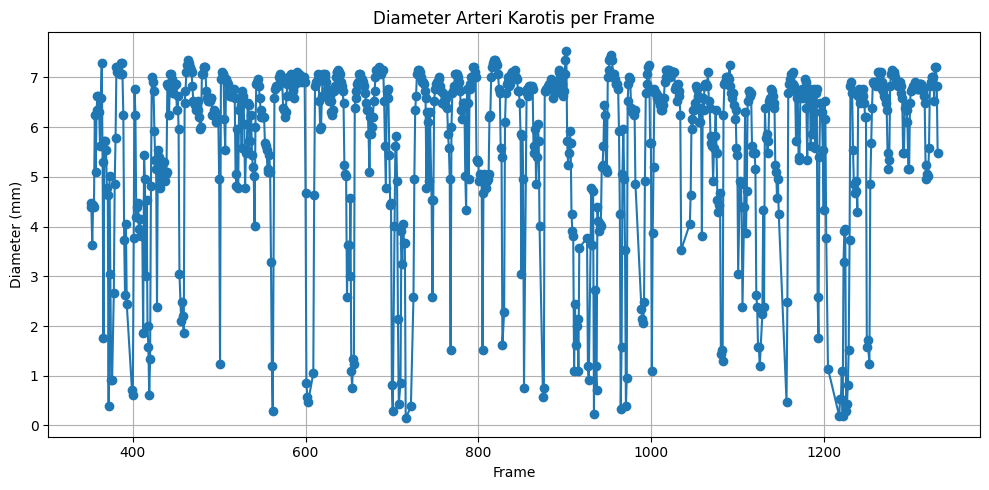

In [29]:
# # Proses segmentasi video dengan overlay kontur
# process_video(
#     video_path=r"D:\Ridho\TA\fix\Subjek1\Subjek1.mp4",
#     model_path="UNet_25Mei_Sore.pth",
#     output_path="subjek1_hasil_segmentasi_video.mp4"
# )

# Segmentasi video dan simpan grafik diameter
process_video_with_diameter(
    video_path=r"D:\Ridho\TA\fix\Subjek1\Subjek1.mp4",
    model_path="UNet_25Mei_Sore.pth",
    output_path="subjek1_hasil_segmentasi_video_diameter.mp4",
    plot_path="subjek1_diameter_vs_frame.png",
    csv_path="subjek1_diameter_data.csv"
)

## Subjek 2

C:\Users\Ridho\AppData\Local\Temp\ipykernel_1636\960485066.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cud

Hasil video disimpan di: subjek2_hasil_segmentasi_video_diameter.mp4
Data diameter disimpan di: subjek2_diameter_data.csv
Plot diameter disimpan di: subjek2_diameter_vs_frame.png


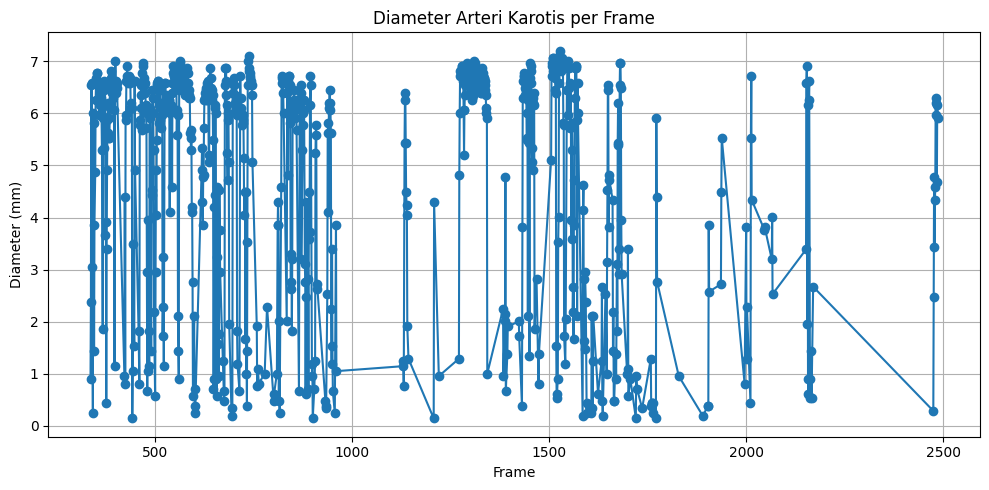

In [30]:
# # Proses segmentasi video dengan overlay kontur
# process_video(
#     video_path=r"D:\Ridho\TA\fix\Subjek2\Subjek2.mp4",
#     model_path="UNet_25Mei_Sore.pth",
#     output_path="subjek2_hasil_segmentasi_video.mp4"
# )

# Segmentasi video dan simpan grafik diameter
process_video_with_diameter(
    video_path=r"D:\Ridho\TA\fix\Subjek2\Subjek2.mp4",
    model_path="UNet_25Mei_Sore.pth",
    output_path="subjek2_hasil_segmentasi_video_diameter.mp4",
    plot_path="subjek2_diameter_vs_frame.png",
    csv_path="subjek2_diameter_data.csv"
)

## Subjek 3

C:\Users\Ridho\AppData\Local\Temp\ipykernel_1636\960485066.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cud

Hasil video disimpan di: subjek3_hasil_segmentasi_video_diameter.mp4
Data diameter disimpan di: subjek3_diameter_data.csv
Plot diameter disimpan di: subjek3_diameter_vs_frame.png


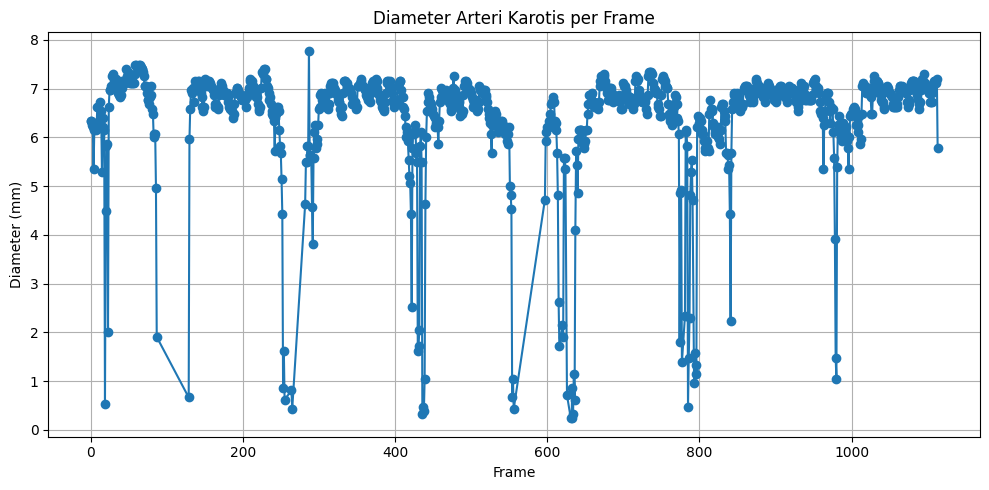

In [31]:
# # Proses segmentasi video dengan overlay kontur
# process_video(
#     video_path=r"D:\Ridho\TA\fix\Subjek3\Subjek3.mp4",
#     model_path="UNet_25Mei_Sore.pth",
#     output_path="subjek3_hasil_segmentasi_video.mp4"
# )

# Segmentasi video dan simpan grafik diameter
process_video_with_diameter(
    video_path=r"D:\Ridho\TA\fix\Subjek3\Subjek3.mp4",
    model_path="UNet_25Mei_Sore.pth",
    output_path="subjek3_hasil_segmentasi_video_diameter.mp4",
    plot_path="subjek3_diameter_vs_frame.png",
    csv_path="subjek3_diameter_data.csv"
)

## Subjek 4

C:\Users\Ridho\AppData\Local\Temp\ipykernel_1636\960485066.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cud

Hasil video disimpan di: subjek4_hasil_segmentasi_video_diameter.mp4
Data diameter disimpan di: subjek4_diameter_data.csv
Plot diameter disimpan di: subjek4_diameter_vs_frame.png


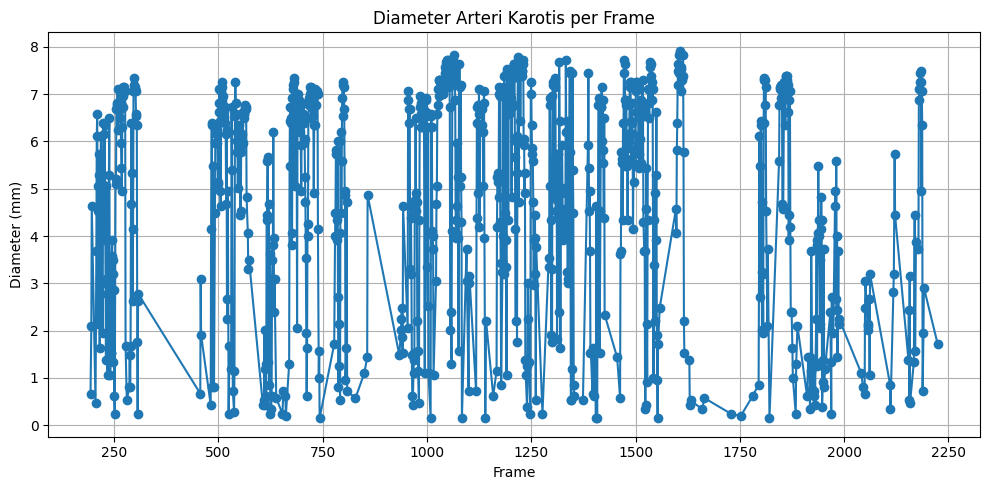

In [32]:
# # Proses segmentasi video dengan overlay kontur
# process_video(
#     video_path=r"D:\Ridho\TA\fix\Subjek4\Subjek4.mp4",
#     model_path="UNet_25Mei_Sore.pth",
#     output_path="subjek4_hasil_segmentasi_video.mp4"
# )

# Segmentasi video dan simpan grafik diameter
process_video_with_diameter(
    video_path=r"D:\Ridho\TA\fix\Subjek4\Subjek4.mp4",
    model_path="UNet_25Mei_Sore.pth",
    output_path="subjek4_hasil_segmentasi_video_diameter.mp4",
    plot_path="subjek4_diameter_vs_frame.png",
    csv_path="subjek4_diameter_data.csv"
)

## Subjek 5

C:\Users\Ridho\AppData\Local\Temp\ipykernel_1636\960485066.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cud

Hasil video disimpan di: subjek5_hasil_segmentasi_video_diameter.mp4
Data diameter disimpan di: subjek5_diameter_data.csv
Plot diameter disimpan di: subjek5_diameter_vs_frame.png


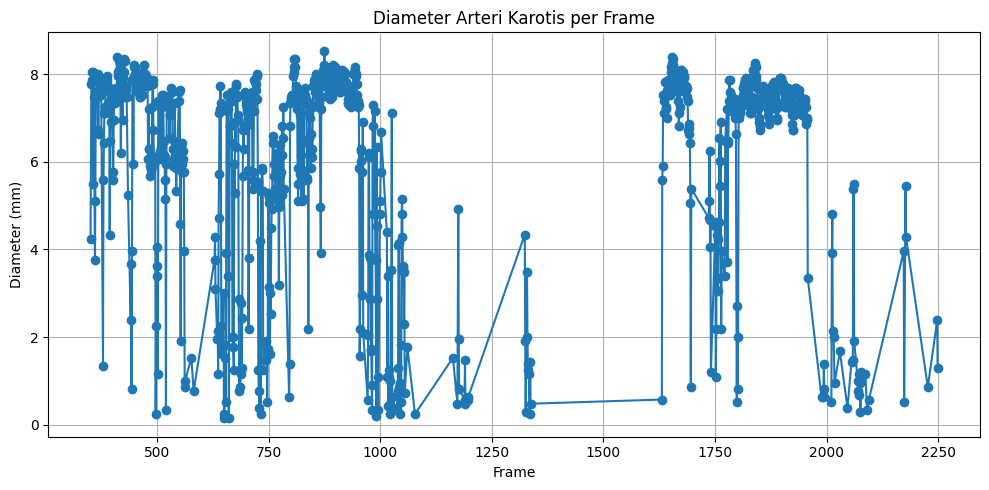

In [33]:
# # Proses segmentasi video dengan overlay kontur
# process_video(
#     video_path=r"D:\Ridho\TA\fix\Subjek5\Subjek5.mp4",
#     model_path="UNet_25Mei_Sore.pth",
#     output_path="subjek5_hasil_segmentasi_video.mp4"
# )

# Segmentasi video dan simpan grafik diameter
process_video_with_diameter(
    video_path=r"D:\Ridho\TA\fix\Subjek5\Subjek5.mp4",
    model_path="UNet_25Mei_Sore.pth",
    output_path="subjek5_hasil_segmentasi_video_diameter.mp4",
    plot_path="subjek5_diameter_vs_frame.png",
    csv_path="subjek5_diameter_data.csv"
)

## Subjek 6

C:\Users\Ridho\AppData\Local\Temp\ipykernel_1636\960485066.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cud

Hasil video disimpan di: subjek6_hasil_segmentasi_video_diameter.mp4
Data diameter disimpan di: subjek6_diameter_data.csv
Plot diameter disimpan di: subjek6_diameter_vs_frame.png


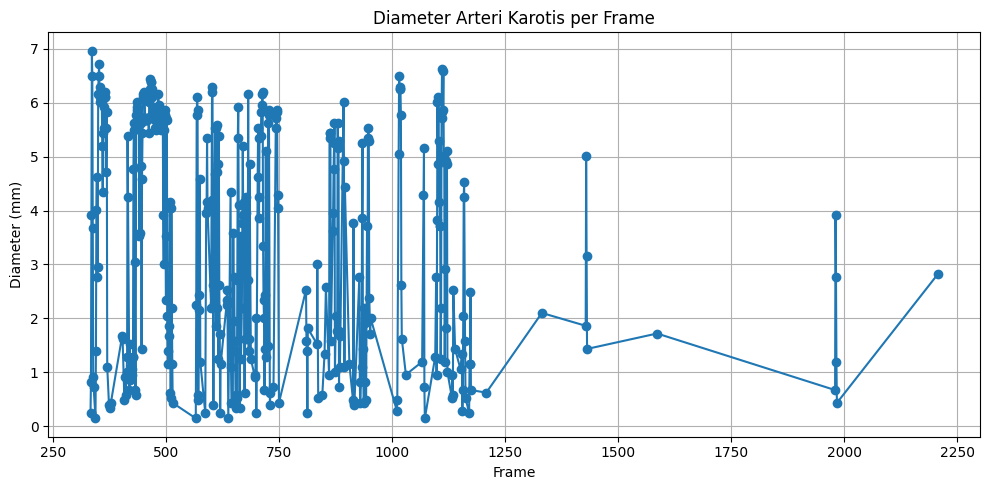

In [34]:
# # Proses segmentasi video dengan overlay kontur
# process_video(
#     video_path=r"D:\Ridho\TA\fix\Subjek6\Subjek6.mp4",
#     model_path="UNet_25Mei_Sore.pth",
#     output_path="subjek6_hasil_segmentasi_video.mp4"
# )

# Segmentasi video dan simpan grafik diameter
process_video_with_diameter(
    video_path=r"D:\Ridho\TA\fix\Subjek6\Subjek6.mp4",
    model_path="UNet_25Mei_Sore.pth",
    output_path="subjek6_hasil_segmentasi_video_diameter.mp4",
    plot_path="subjek6_diameter_vs_frame.png",
    csv_path="subjek6_diameter_data.csv"
)

## Subjek 7

C:\Users\Ridho\AppData\Local\Temp\ipykernel_1636\960485066.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cud

Hasil video disimpan di: subjek7_hasil_segmentasi_video_diameter.mp4
Data diameter disimpan di: subjek7_diameter_data.csv
Plot diameter disimpan di: subjek7_diameter_vs_frame.png


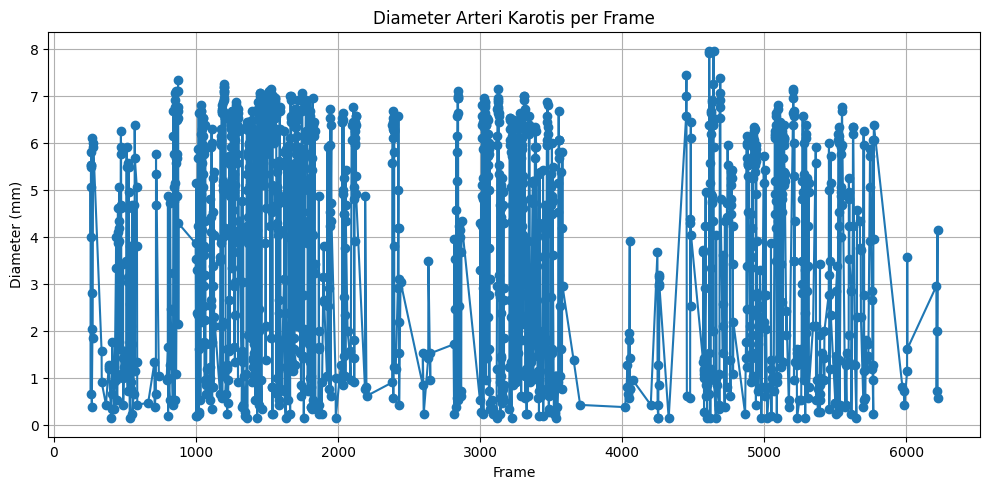

In [35]:
# # Proses segmentasi video dengan overlay kontur
# process_video(
#     video_path=r"D:\Ridho\TA\fix\Subjek7\Subjek7.mp4",
#     model_path="UNet_25Mei_Sore.pth",
#     output_path="subjek7_hasil_segmentasi_video.mp4"
# )

# Segmentasi video dan simpan grafik diameter
process_video_with_diameter(
    video_path=r"D:\Ridho\TA\fix\Subjek7\Subjek7.mp4",
    model_path="UNet_25Mei_Sore.pth",
    output_path="subjek7_hasil_segmentasi_video_diameter.mp4",
    plot_path="subjek7_diameter_vs_frame.png",
    csv_path="subjek7_diameter_data.csv"
)

## 12. Sinkronisasi Data Tekanan dan Citra


In [16]:

def sync_pressure_with_image_data(subject_number):
    """
    Sinkronkan data tekanan dan diameter berdasarkan timestamps.
    
    Args:
        subject_number (int): Nomor subjek (1-7)
    
    Returns:
        pandas.DataFrame: DataFrame yang berisi data yang telah disinkronkan
    """
    # Baca file timestamps.csv dan subject{X}.csv
    base_path = rf"D:\Ridho\TA\fix\Subjek{subject_number}"
    timestamp_path = os.path.join(base_path, "timestamps.csv")
    pressure_path = os.path.join(base_path, f"subject{subject_number}.csv")
    diameter_path = f"subjek{subject_number}_diameter_data.csv"
    
    # Baca data
    try:
        timestamps_df = pd.read_csv(timestamp_path)
        pressure_df = pd.read_csv(pressure_path)
        diameter_df = pd.read_csv(diameter_path)
        
        # Konversi timestamps ke datetime untuk timestamps_df
        if 'timestamps' in timestamps_df.columns:
            timestamps_df['timestamps'] = pd.to_datetime(timestamps_df['timestamps'])
        elif 'timestamps' in timestamps_df.columns:
            timestamps_df['timestamps'] = pd.to_datetime(timestamps_df['timestamps'])
            timestamps_df = timestamps_df.rename(columns={'timestamps': 'timestamps'})
            
        # Konversi timestamps ke datetime untuk pressure_df
        if 'timestamps' in pressure_df.columns:
            pressure_df['timestamps'] = pd.to_datetime(pressure_df['timestamps'])
        elif 'timestamps' in pressure_df.columns:
            pressure_df['timestamps'] = pd.to_datetime(pressure_df['timestamps'])
            pressure_df = pressure_df.rename(columns={'timestamps': 'timestamps'})
        
        # Merge data diameter dengan timestamps berdasarkan frame
        synced_data = pd.merge(timestamps_df, diameter_df, left_on='frame', right_on='Frame')
        
        # Interpolasi data tekanan ke timestamps video
        pressure_interpolator = interp1d(pressure_df['timestamps'].astype(np.int64), 
                                       pressure_df['pressure'], 
                                       bounds_error=False,
                                       fill_value="extrapolate")
                                       
        synced_data['pressure'] = pressure_interpolator(synced_data['timestamps'].astype(np.int64))
        
        # Simpan hasil
        output_path = os.path.join(base_path, f"synced_data_subject{subject_number}.csv")
        synced_data.to_csv(output_path, index=False)
        
        # Visualisasi
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Plot diameter
        ax1.plot(synced_data['timestamps'], synced_data['Diameter (mm)'], 'b-', label='Diameter')
        ax1.set_ylabel('Diameter (mm)')
        ax1.set_title(f'Diameter dan Tekanan vs Waktu - Subjek {subject_number}')
        ax1.grid(True)
        ax1.legend()
        
        # Plot tekanan
        ax2.plot(synced_data['timestamps'], synced_data['pressure'], 'r-', label='Tekanan')
        ax2.set_ylabel('Tekanan (mmHg)')
        ax2.set_xlabel('Waktu')
        ax2.grid(True)
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(base_path, f"pressure_diameter_sync_subject{subject_number}.png"))
        plt.close()
        
        return synced_data
        
    except FileNotFoundError as e:
        print(f"Error: File tidak ditemukan - {e}")
        return None
    except Exception as e:
        print(f"Error: Terjadi kesalahan - {e}")
        print(f"Detail error: {str(e)}")  # Tambahan untuk debug
        return None

def process_all_subjects():
    """
    Proses sinkronisasi untuk semua subjek (1-7)
    """
    results = {}
    for subject in range(1, 8):
        print(f"\nMemproses Subjek {subject}...")
        result = sync_pressure_with_image_data(subject)
        if result is not None:
            results[f"subject_{subject}"] = result
            print(f"Sinkronisasi data Subjek {subject} berhasil")
    return results

# Import tambahan yang diperlukan
from scipy.interpolate import interp1d

In [18]:
## 13. Pemanggilan Fungsi Sinkronisasi Data

# Sinkronisasi untuk satu subjek tertentu (contoh: Subjek 1)
synced_data_subject1 = sync_pressure_with_image_data(1)

if synced_data_subject1 is not None:
    print("\nStatistik data tersinkronisasi Subjek 1:")
    print(f"Jumlah data: {len(synced_data_subject1)}")
    print("\nRata-rata:")
    print(f"Diameter: {synced_data_subject1['Diameter (mm)'].mean():.2f} mm")
    print(f"Tekanan: {synced_data_subject1['pressure'].mean():.2f} mmHg")
    print("\nStandar deviasi:")
    print(f"Diameter: {synced_data_subject1['Diameter (mm)'].std():.2f} mm")
    print(f"Tekanan: {synced_data_subject1['pressure'].std():.2f} mmHg")

# Sinkronisasi untuk semua subjek
print("\nMemulai sinkronisasi untuk semua subjek...")
all_synced_data = process_all_subjects()

# Analisis hasil sinkronisasi semua subjek
if all_synced_data:
    print("\nRingkasan hasil sinkronisasi semua subjek:")
    for subject_key, data in all_synced_data.items():
        print(f"\n{subject_key.upper()}:")
        print(f"Jumlah frame: {len(data)}")
        print(f"Range Diameter: {data['Diameter (mm)'].min():.2f} - {data['Diameter (mm)'].max():.2f} mm")
        print(f"Range Tekanan: {data['pressure'].min():.2f} - {data['pressure'].max():.2f} mmHg")

Error: Terjadi kesalahan - 'frame'
Detail error: 'frame'

Memulai sinkronisasi untuk semua subjek...

Memproses Subjek 1...
Error: Terjadi kesalahan - 'frame'
Detail error: 'frame'

Memproses Subjek 2...
Error: Terjadi kesalahan - 'frame'
Detail error: 'frame'

Memproses Subjek 3...
Error: Terjadi kesalahan - 'frame'
Detail error: 'frame'

Memproses Subjek 4...
Error: Terjadi kesalahan - 'frame'
Detail error: 'frame'

Memproses Subjek 5...
Error: File tidak ditemukan - [Errno 2] No such file or directory: 'D:\\Ridho\\TA\\fix\\Subjek5\\subject5.csv'

Memproses Subjek 6...
Error: Terjadi kesalahan - 'frame'
Detail error: 'frame'

Memproses Subjek 7...
Error: Terjadi kesalahan - 'frame'
Detail error: 'frame'
